In [11]:
import sys
import os

PROJECT_ROOT = "/home/jack_li/python/LOB_research/fetch_data/process"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from process import process_lob

process_lob.hello_lob()



hello_lob


In [1]:
#合并下载数据
import pandas as pd
import os
import glob

import pandas as pd
import glob
import os

def merge_parquet(folder, output_file):
    files = glob.glob(os.path.join(folder, "*.parquet"))
    
    if not files:
        print("未找到Parquet文件。")
        return

    dfs = []
    # 如果输出文件也在这个文件夹里，需要避免把它自己也读进去（取决于你的文件名规则）
    # 建议先过滤掉 output_file
    files = [f for f in files if os.path.abspath(f) != os.path.abspath(output_file)]

    for f in files:
        try:
            df = pd.read_parquet(f)
            dfs.append(df)
        except Exception as e:
            print(f"跳过损坏文件: {f}, 错误: {e}")
    
    if not dfs:
        print("没有有效的数据被读取。")
        return

    # 合并数据
    df_merged = pd.concat(dfs, axis=0, ignore_index=True)
    df_merged = df_merged.dropna(axis=1, how='all')
    
    # ---------------------------------------------------------
    # 关键修改：步骤 1 - 先尝试保存文件
    # ---------------------------------------------------------
    try:
        folder = os.path.dirname(output_file)

        # 如果目录不存在就创建
        os.makedirs(folder, exist_ok=True)

        # 保存 parquet
        df_merged.to_parquet(output_file)
        print(f"合并成功，文件已保存至: {output_file}")
        
        # -----------------------------------------------------
        # 关键修改：步骤 2 - 保存成功后，不删除源文件
        # -----------------------------------------------------
                
        print("全部完成。")
        
    except Exception as e:
        # 如果保存失败，打印错误，并且绝对不要删除源文件
        print(f"!!! 保存失败 !!! 源文件未被删除。错误信息: {e}")
        
#合并trades数据
markets=['ETH','BTC','SOL']
year=2025
mounth=12
days=['14']
for market in markets:
    for day in days:

        input_path=f"/home/jack_li/python/LOB_research/fetch_data/data/{year}-{mounth}-{day}/{market}/trades/"
        output_path=f"/home/jack_li/python/LOB_research/fetch_data/data/{year}-{mounth}-{day}/{market}/trades/merged.parquet"
        print(input_path)
        print(output_path)
        merge_parquet(input_path, output_path)
days=['14']

for market in markets:
    for day in days:
        input_path=f"/home/jack_li/python/LOB_research/fetch_data/data/{year}-{mounth}-{day}/{market}/trades/"
        output_path=f"/home/jack_li/python/LOB_research/fetch_data/data/{market}/trades/merged.parquet"
        if os.path.exists(output_path):
            os.remove(output_path)

for market in markets:
    for day in days:
        input_path=f"/home/jack_li/python/LOB_research/fetch_data/data/{year}-{mounth}-{day}/{market}/trades/"
        output_path=f"/home/jack_li/python/LOB_research/fetch_data/data/{market}/trades/merged.parquet"
        print(input_path)
        print(output_path)
        df=pd.read_parquet(input_path)
        df.to_parquet(
            output_path, 
            compression='snappy', 
            engine='fastparquet',  # 必须指定引擎
            append=os.path.exists(output_path)     # 文件存在时追加，不存在时新建
        )
        
        


/home/jack_li/python/LOB_research/fetch_data/data/2025-12-14/ETH/trades/
/home/jack_li/python/LOB_research/fetch_data/data/2025-12-14/ETH/trades/merged.parquet
合并成功，文件已保存至: /home/jack_li/python/LOB_research/fetch_data/data/2025-12-14/ETH/trades/merged.parquet
全部完成。
/home/jack_li/python/LOB_research/fetch_data/data/2025-12-14/BTC/trades/
/home/jack_li/python/LOB_research/fetch_data/data/2025-12-14/BTC/trades/merged.parquet
合并成功，文件已保存至: /home/jack_li/python/LOB_research/fetch_data/data/2025-12-14/BTC/trades/merged.parquet
全部完成。
/home/jack_li/python/LOB_research/fetch_data/data/2025-12-14/SOL/trades/
/home/jack_li/python/LOB_research/fetch_data/data/2025-12-14/SOL/trades/merged.parquet
合并成功，文件已保存至: /home/jack_li/python/LOB_research/fetch_data/data/2025-12-14/SOL/trades/merged.parquet
全部完成。
/home/jack_li/python/LOB_research/fetch_data/data/2025-12-14/ETH/trades/
/home/jack_li/python/LOB_research/fetch_data/data/ETH/trades/merged.parquet
/home/jack_li/python/LOB_research/fetch_data/data/202

In [2]:
#将
import pandas as pd
import numpy as np

def sample_lob_by_dollar_volume(lob_df, trades_df, threshold):
    """
    基于成交额阈值对LOB数据进行采样。
    
    参数:
    lob_df (pd.DataFrame): LOB数据，Index为datetime
    trades_df (pd.DataFrame): 成交数据，Index为datetime，必须包含 'values' 列
    threshold (float): 美元成交额阈值 (Dollar Bar Threshold)
    
    返回:
    pd.DataFrame: 采样后的LOB数据，包含 'interval_volume' 和 'skipped_snapshots'
    """
    # 1. 数据对齐与预处理
    # 确保数据按时间排序
    lob_df = lob_df.sort_index()
    trades_df = trades_df.sort_index()
    
    # 提取numpy数组以加速计算
    lob_times = lob_df.index.values
    trade_times = trades_df.index.values
    trade_values = trades_df['values'].values
    
    # 2. 计算成交额的累积和 (Cumulative Sum)
    # 在头部插入0，方便计算差值
    trade_cum_vol = np.concatenate(([0], np.cumsum(trade_values)))
    
    # 3. 将 LOB 的时间戳映射到 Trade 的累积成交额索引上
    # searchsorted(side='right') 会找到 <= lob_time 的所有 trade 的最后一个索引
    # 这意味着我们获取的是截止到该 LOB 切片时刻的总累计成交额
    idx_map = np.searchsorted(trade_times, lob_times, side='right')
    
    # 获取每个 LOB 切片时刻对应的全局累计成交额
    lob_snapshot_cum_vols = trade_cum_vol[idx_map]
    
    # 4. 核心逻辑：遍历并判定阈值
    # 这里虽然用了循环，但是是对一维数组的简单操作，比操作DataFrame快几个数量级
    
    keep_indices = []       # 保留的 LOB 行号索引
    interval_volumes = []   # 该区间的实际成交额
    skipped_counts = []     # 跳过的切片数量
    
    last_accepted_vol = lob_snapshot_cum_vols[0] # 上一次被保留切片时的累计成交额
    current_skipped = 0     # 当前累积跳过的切片数
    
    # 从第1行开始遍历 (第0行通常作为基准或根据需求决定，这里我们计算从第0行之后的变化)
    for i in range(1, len(lob_times)):
        current_vol = lob_snapshot_cum_vols[i]
        
        # 计算当前切片与上一个"保留切片"之间的成交额差值
        vol_diff = current_vol - last_accepted_vol
        
        if vol_diff >= threshold:
            # 触发阈值，保留该切片
            keep_indices.append(i)
            interval_volumes.append(vol_diff)
            skipped_counts.append(current_skipped)
            
            # 更新状态
            last_accepted_vol = current_vol
            current_skipped = 0
        else:
            # 未达到阈值，跳过
            current_skipped += 1
            
    # 5. 构建输出 DataFrame
    if not keep_indices:
        return pd.DataFrame() # 如果没有切片满足条件
        
    sampled_df = lob_df.iloc[keep_indices].copy()
    sampled_df['interval_volume'] = interval_volumes
    sampled_df['skipped_snapshots'] = skipped_counts
    
    return sampled_df

# ==========================================
# 下面是测试用例 (帮你生成假数据来验证)
# ==========================================


# 2. 设置阈值并运行
THRESHOLD = 5000 # 每成交 5000 USD 采样一次 LOB
df_LOB = pd.read_parquet(r'/home/jack_li/python/LOB_research/fetch_data/data/BTC/LOB/processed_merged.parquet')
df_LOB['datetime'] = pd.to_datetime(df_LOB['exchange_time'], unit='ms')
df_LOB = df_LOB.set_index('datetime')
df_trades = pd.read_parquet(r'/home/jack_li/python/LOB_research/fetch_data/data/BTC/trades/merged.parquet')
df_trades['datetime'] = pd.to_datetime(df_trades['exchange_time'], unit='ms')
df_trades = df_trades.set_index('datetime')
df_trades['values']=df_trades['px'].astype(float)*df_trades['sz'].astype(float)
result = sample_lob_by_dollar_volume(df_LOB, df_trades, THRESHOLD)

# 3. 打印结果
print(f"原始 LOB 切片数: {len(df_LOB)}")
print(f"原始 Trades 数: {len(df_trades)}")
print(f"采样后 LOB 切片数: {len(result)}")
print("-" * 30)
print("采样结果前5行:")
print(result[['interval_volume', 'skipped_snapshots']].head())
result.to_parquet("/home/jack_li/python/LOB_research/fetch_data/data/BTC/LOB_Dollar_bar/data.parquet")


原始 LOB 切片数: 46196
原始 Trades 数: 65770
采样后 LOB 切片数: 2491
------------------------------
采样结果前5行:
                         interval_volume  skipped_snapshots
datetime                                                   
2025-12-14 00:00:31.647      24913.07472                  6
2025-12-14 00:00:32.735      19557.02448                  1
2025-12-14 00:00:52.053       5434.56954                 35
2025-12-14 00:00:57.907      27333.04014                 10
2025-12-14 00:01:07.757      21256.03326                 17


In [15]:
df_LOB = pd.read_parquet(r'/home/jack_li/python/LOB_research/fetch_data/data/BTC/LOB/processed_merged.parquet')
df_LOB['datetime'] = pd.to_datetime(df_LOB['exchange_time'], unit='ms')
df_LOB = df_LOB.set_index('datetime')
df_trades = pd.read_parquet(r'/home/jack_li/python/LOB_research/fetch_data/data/BTC/trades/merged.parquet')
df_trades['datetime'] = pd.to_datetime(df_trades['exchange_time'], unit='ms')
df_trades = df_trades.set_index('datetime')

In [16]:
print(df_LOB.head())
print(df_trades.head())

                         exchange_time  ask_px_0  ask_px_1  ask_px_2  \
datetime                                                               
2025-12-12 01:30:25.457  1765503025457     92016     92017     92018   
2025-12-12 01:30:25.959  1765503025959     92016     92017     92018   
2025-12-12 01:30:26.469  1765503026469     92016     92017     92018   
2025-12-12 01:30:27.082  1765503027082     92016     92017     92018   
2025-12-12 01:30:27.550  1765503027550     92016     92017     92018   

                         ask_px_3  ask_px_4  ask_px_5  ask_px_6  ask_px_7  \
datetime                                                                    
2025-12-12 01:30:25.457     92019     92020     92022     92023     92024   
2025-12-12 01:30:25.959     92019     92020     92021     92022     92023   
2025-12-12 01:30:26.469     92019     92020     92021     92022     92023   
2025-12-12 01:30:27.082     92019     92020     92022     92023     92024   
2025-12-12 01:30:27.550     92019

In [ ]:
df_trades

正在计算微观结构特征...
正在计算 OBI 的自相关性衰减 (Lags=50)...

=== 关键指标对比 ===
Feature: OBI
Lag-1 Autocorrelation (Time Bars):   0.9550
Lag-1 Autocorrelation (Dollar Bars): 0.6233
Lag-10 Autocorrelation (Time Bars):  0.7181
Lag-10 Autocorrelation (Dollar Bars):0.0079

Lag-1 Ratio (Dollar / Time): 0.65
结论: Dollar Bars 显著降低了特征的序列冗余，验证成功。


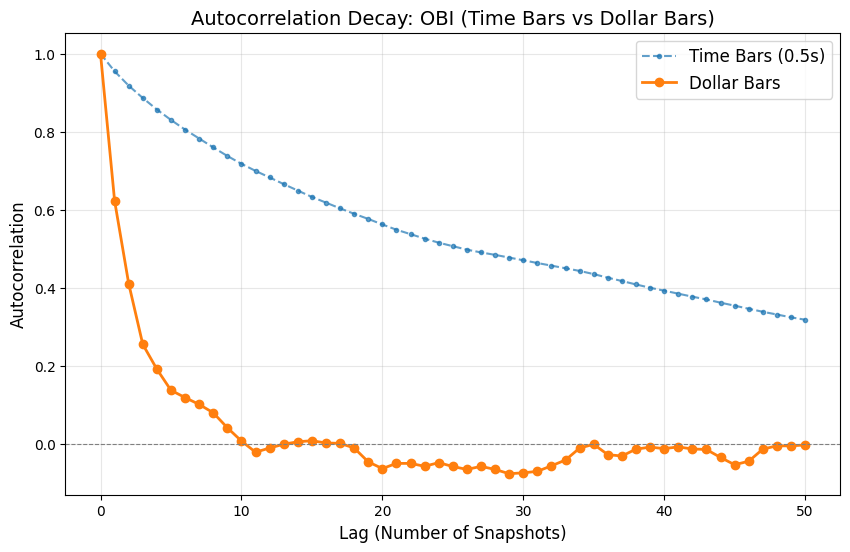

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

def calculate_microstructure_features(df):
    """
    计算 LOB 微观结构特征 (OBI 和 Spread)
    假设 Top of Book 列名为: 'ask_px_0', 'bid_px_0', 'ask_sz_0', 'bid_sz_0'
    如果你的列名是从 1 开始 (如 bid_sz_1)，请相应调整列名变量。
    """
    df_features = df.copy()
    
    ap0 = 'ask_px_0' 
    bp0 = 'bid_px_0' 
    as0 = 'ask_sz_0' 
    bs0 = 'bid_sz_0' 
    
    # 1. Calculate Spread (Ask - Bid)
    # 注意：如果数据中有异常值导致 Ask < Bid，Spread 可能为负，通常需要过滤或取绝对值
    df_features['spread'] = df_features[ap0] - df_features[bp0]
    
    # 2. Calculate Order Book Imbalance (OBI)
    # Formula: bid_sz / (bid_sz + ask_sz)
    # 范围 [0, 1], 0.5 表示平衡
    total_size = df_features[bs0] + df_features[as0]
    # 避免除以 0
    df_features['OBI'] = df_features[bs0] / total_size.replace(0, np.nan)
    
    # 填充 NaN (比如没有 volume 的时刻，虽少见)
    df_features['OBI'] = df_features['OBI'].fillna(0.5) 
    
    return df_features

def calculate_session_acf(df, feature_col, nlags=50):
    """
    计算分组(session)加权的平均自相关系数 (Average ACF)
    """
    acf_results = []
    
    # 按 Session 分组计算，避免跨 Session 的数据干扰 Lag 计算
    sessions = df['session_id'].unique()
    
    for session in sessions:
        session_data = df[df['session_id'] == session][feature_col]
        
        # 只有数据长度大于 Lag 数才有意义
        if len(session_data) > nlags:
            # fft=True 通常更快
            lag_corr = acf(session_data, nlags=nlags, fft=True)
            acf_results.append(lag_corr)
            
    if not acf_results:
        return np.zeros(nlags + 1)
        
    # 计算所有 Session 的平均 ACF 曲线
    avg_acf = np.mean(acf_results, axis=0)
    return avg_acf

# ==========================================
# 假设 df_LOB 和 df_dollar_bar_lob 已经在内存中
# 如果没有加载，请先加载你的数据
# ==========================================

# 1. 计算特征
print("正在计算微观结构特征...")
df_LOB_feat = calculate_microstructure_features(df_LOB)
df_dollar_feat = calculate_microstructure_features(result)

# 2. 计算自相关性 (ACF)
# 针对 "连续100个快照" 的输入窗口，我们关注前 20-50 个 Lag 的衰减情况
LAG_N = 50 
feature_name = 'OBI' # 可以换成 'spread'

print(f"正在计算 {feature_name} 的自相关性衰减 (Lags={LAG_N})...")
acf_time = calculate_session_acf(df_LOB_feat, feature_name, nlags=LAG_N)
acf_dollar = calculate_session_acf(df_dollar_feat, feature_name, nlags=LAG_N)

# 3. 可视化对比
plt.figure(figsize=(10, 6))

lags = range(len(acf_time))
plt.plot(lags, acf_time, label='Time Bars (0.5s)', marker='.', linestyle='--', alpha=0.7)
plt.plot(lags, acf_dollar, label='Dollar Bars', marker='o', linewidth=2)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title(f'Autocorrelation Decay: {feature_name} (Time Bars vs Dollar Bars)', fontsize=14)
plt.xlabel('Lag (Number of Snapshots)', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# 4. 打印关键指标
print("\n=== 关键指标对比 ===")
print(f"Feature: {feature_name}")
print(f"Lag-1 Autocorrelation (Time Bars):   {acf_time[1]:.4f}")
print(f"Lag-1 Autocorrelation (Dollar Bars): {acf_dollar[1]:.4f}")
print(f"Lag-10 Autocorrelation (Time Bars):  {acf_time[10]:.4f}")
print(f"Lag-10 Autocorrelation (Dollar Bars):{acf_dollar[10]:.4f}")

decay_ratio = acf_dollar[1] / acf_time[1]
print(f"\nLag-1 Ratio (Dollar / Time): {decay_ratio:.2f}")
if decay_ratio < 0.9:
    print("结论: Dollar Bars 显著降低了特征的序列冗余，验证成功。")
else:
    print("结论: 两者差异不大，可能需要调整 Dollar Bar 的阈值。")

plt.show()

In [4]:
import pandas as pd
import numpy as np

def apply_triple_barrier_labeling(df, 
                                  price_col='mid_price', 
                                  vol_col='volatility',
                                  vertical_barrier_n=20, 
                                  pt=1.0, 
                                  sl=1.0,
                                  min_ret=0.0005):
    """
    针对 Dollar Bars 的三势垒标记法 (Triple Barrier Method)。
    
    参数:
    - df: 包含价格和 session_id 的 DataFrame
    - vertical_barrier_n: 垂直势垒（窗口长度），即向后看多少个 Dollar Bars
    - pt: 止盈乘数 (Profit Taking multiplier)，基于波动率或固定阈值
    - sl: 止损乘数 (Stop Loss multiplier)
    - min_ret: 最小目标回报 (如果是固定阈值法，这个就是你的固定阈值，例如 0.05%)
    
    返回:
    - 带有 'label' 和 'ret' (实际收益) 的 DataFrame
    """
    
    # 1. 确保数据经过排序
    df = df.sort_values(['session_id', 'datetime']).reset_index(drop=True)
    
    # 2. 如果没有 mid_price，先计算
    if price_col not in df.columns:
        # 兼容你的列名，假设 ask_px_0 和 bid_px_0 存在
        # 注意：如果列名是 1-based (ask_px_1)，请自行修改
        ap = 'ask_px_0' if 'ask_px_0' in df.columns else 'ask_px_1'
        bp = 'bid_px_0' if 'bid_px_0' in df.columns else 'bid_px_1'
        df[price_col] = (df[ap] + df[bp]) / 2.0

    # 3. 定义动态阈值 (Target)
    # 如果 vol_col 存在，使用动态波动率 * pt/sl；否则使用固定 min_ret
    # 对于高频 LOB，固定阈值通常更容易开始 (例如 5-10 ticks)
    use_dynamic_vol = vol_col in df.columns
    
    out_labels = []
    
    # 按 Session 分组处理，防止跨天标记
    for session, group in df.groupby('session_id'):
        group = group.copy()
        
        # --- 核心逻辑: 向量化查找首个触碰点 ---
        
        # 1. 构建未来 N 步的价格矩阵 (Look-forward matrix)
        # 每一列代表未来第 i 个 Bar 的价格
        future_prices = pd.DataFrame({
            i: group[price_col].shift(-i) 
            for i in range(1, vertical_barrier_n + 1)
        })
        
        # 2. 计算相对于当前时刻 t 的收益率
        current_price = group[price_col].values
        # 利用广播机制计算 returns: (Future - Current) / Current
        returns_matrix = future_prices.sub(current_price, axis=0).div(current_price, axis=0)
        
        # 3. 确定上下界阈值
        if use_dynamic_vol:
            # 动态阈值: Target = Volatility_t
            target = group[vol_col].values
            upper_bound = target * pt
            lower_bound = -target * sl
            
            # 过滤太小的波动目标
            upper_bound = np.maximum(upper_bound, min_ret)
            lower_bound = np.minimum(lower_bound, -min_ret)
        else:
            # 固定阈值
            upper_bound = np.full(len(group), min_ret * pt)
            lower_bound = np.full(len(group), -min_ret * sl)
        
        # 4. 寻找触碰时间
        # 这里的逻辑是：每一行代表一个 t，我们要看这一行里哪一列(1~N)最先出界
        
        # 标记触碰上界的位置 (True/False)
        # 注意：returns_matrix 的列名是 1..N，需要转为 numpy 比较
        hit_upper = returns_matrix.ge(upper_bound[:, None]) # ge: >=
        hit_lower = returns_matrix.le(lower_bound[:, None]) # le: <=
        
        # 找到第一个触碰的时间索引 (argmax 返回第一个 True 的索引，如果没有 True 返回 0)
        # 为了区分“没有触碰”和“第0个触碰”，我们需要先判断是否有触碰
        has_hit_upper = hit_upper.any(axis=1)
        has_hit_lower = hit_lower.any(axis=1)
        
        # 获取触碰的相对位置 (1 到 vertical_barrier_n)
        first_upper_idx = hit_upper.idxmax(axis=1)
        first_lower_idx = hit_lower.idxmax(axis=1)
        
        # --- 裁决 (Arbitration) ---
        # 逻辑：
        # - 如果只碰上界 -> 1
        # - 如果只碰下界 -> -1
        # - 如果都碰 -> 看谁先碰 (index 越小越早)
        # - 都不碰 -> 0
        
        session_labels = pd.Series(0, index=group.index) # 默认为 0
        
        # Case 1: 这是一个纯数学逻辑，可以用 numpy where 优化，但为了可读性写成 Series 操作
        
        # 两个都碰的情况
        both_hit = has_hit_upper & has_hit_lower
        
        # 上界先于或同时于下界 (Upper <= Lower index) -> 1
        # 注意：idxmax 返回的是列名(1..N)，是可以比较的
        up_wins = both_hit & (first_upper_idx <= first_lower_idx)
        down_wins = both_hit & (first_upper_idx > first_lower_idx)
        
        session_labels[up_wins] = 1
        session_labels[down_wins] = -1
        
        # 只有一个碰的情况
        only_up = has_hit_upper & (~has_hit_lower)
        only_down = has_hit_lower & (~has_hit_upper)
        
        session_labels[only_up] = 1
        session_labels[only_down] = -1
        
        out_labels.append(session_labels)
        
    # 合并所有 session 的结果
    df[f'label'] = pd.concat(out_labels).sort_index()
    
    # 移除最后 vertical_barrier_n 行 (因为它们没有足够的未来数据来标记)
    # 或者保留它们但标记为 NaN/0
    df = df.dropna(subset=['label'])
    
    return df

def get_volatility(df, price_col='mid_price', span=100):
    """
    计算基于 Dollar Bars 的波动率 (作为动态阈值的基础)
    通常使用 EWM 标准差
    """
    # 计算对数收益率
    df['log_ret'] = np.log(df[price_col] / df[price_col].shift(1))
    # EWM Std Dev
    return df['log_ret'].ewm(span=span).std()

# ==========================================
# 使用示例
# ==========================================
df_dollar_bar_lob=pd.read_parquet('/home/jack_li/python/LOB_research/fetch_data/data/BTC/LOB_Dollar_bar/data.parquet')
# 1. 准备数据 (假设 df_dollar_bar_lob 已经存在)
print("1. 计算 Mid Price...")
# 如果还没计算 mid_price
if 'mid_price' not in df_dollar_bar_lob.columns:
    # 检查你的列名是 ask_px_0 还是 ask_px_1
    ap = 'ask_px_0'
    bp = 'bid_px_0'
    df_dollar_bar_lob['mid_price'] = (df_dollar_bar_lob[ap] + df_dollar_bar_lob[bp]) / 2

# 2. (可选) 计算动态波动率
# 如果你想用固定阈值 (比如涨跌 0.05% 就止盈)，可以跳过这步
print("2. 计算动态波动率 (可选)...")
df_dollar_bar_lob['volatility'] = get_volatility(df_dollar_bar_lob, span=50)

# 3. 运行 Triple Barrier
# 参数解释：
# vertical_barrier_n=20 : 你的模型看未来 20 个 Dollar Bars 的走势
# min_ret=0.0002 : 也就是 0.02% (2个基点)。如果是高频，这个值要很小。
# pt=1, sl=1 : 止盈和止损距离相等
print("3. 生成标签 (Labeling)...")

# 方式 A: 固定阈值 (适合初学者/高频Scalping)
# 只要未来 20 个 Bar 内涨了 0.02% 就标记 1，跌了 0.02% 就标记 -1
df_labeled = apply_triple_barrier_labeling(
    df_dollar_bar_lob, 
    vertical_barrier_n=20, 
    min_ret=0.001,  # 阈值：2 bps (根据你的资产波动性调整)
    pt=1, 
    sl=1
    # 不传 vol_col，则强制使用固定 min_ret
)

# 方式 B: 动态阈值 (适合波动率变化剧烈的市场)
# 阈值 = 当前波动率 * 1
# df_labeled = apply_triple_barrier_labeling(
#     df_dollar_bar_lob, 
#     vol_col='volatility',
#     vertical_barrier_n=20,
#     pt=1, sl=1, min_ret=0.0001
# )

# 4. 检查标签分布
print("\n=== 标签分布 ===")
print(df_labeled['label'].value_counts(normalize=True))
print("\n如果不平衡 (比如 0 太多)，请减小 min_ret 或 增加 vertical_barrier_n")


1. 计算 Mid Price...
2. 计算动态波动率 (可选)...
3. 生成标签 (Labeling)...

=== 标签分布 ===
label
 0    0.971096
-1    0.028904
Name: proportion, dtype: float64

如果不平衡 (比如 0 太多)，请减小 min_ret 或 增加 vertical_barrier_n


In [5]:
df_labeled.to_parquet('/home/jack_li/python/LOB_research/fetch_data/data/BTC/LOB_Dollar_bar/predict_data_label.parquet')

In [21]:
df_labeled.columns

Index(['exchange_time', 'ask_px_0', 'ask_px_1', 'ask_px_2', 'ask_px_3',
       'ask_px_4', 'ask_px_5', 'ask_px_6', 'ask_px_7', 'ask_px_8', 'ask_px_9',
       'bid_px_0', 'bid_px_1', 'bid_px_2', 'bid_px_3', 'bid_px_4', 'bid_px_5',
       'bid_px_6', 'bid_px_7', 'bid_px_8', 'bid_px_9', 'ask_sz_0', 'ask_sz_1',
       'ask_sz_2', 'ask_sz_3', 'ask_sz_4', 'ask_sz_5', 'ask_sz_6', 'ask_sz_7',
       'ask_sz_8', 'ask_sz_9', 'bid_sz_0', 'bid_sz_1', 'bid_sz_2', 'bid_sz_3',
       'bid_sz_4', 'bid_sz_5', 'bid_sz_6', 'bid_sz_7', 'bid_sz_8', 'bid_sz_9',
       'label_5', 'label_10', 'label_30', 'label_50', 'session_id',
       'interval_volume', 'skipped_snapshots', 'mid_price', 'log_ret',
       'volatility', 'label'],
      dtype='object')

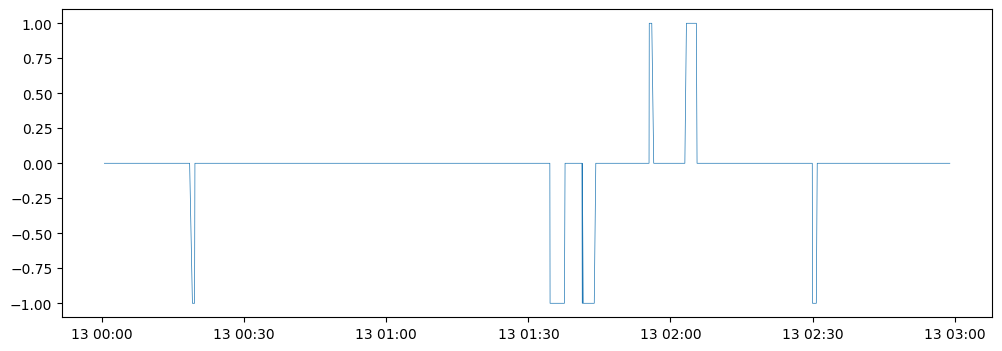

KeyError: 'exchange_time'

<Figure size 1200x400 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设你的 DataFrame 叫 df
df_plot = df_labeled[['exchange_time', 'label']].copy()

# 毫秒时间戳 → datetime（非常重要）
df_plot['exchange_time'] = pd.to_datetime(df_plot['exchange_time'], unit='ms')
df_plot = df_plot.set_index('exchange_time').sort_index()
start = '2025-12-12 09:30:00'
end   = '2025-12-13 03:00:00'

df_win = df_plot.loc[start:end]

plt.figure(figsize=(12,4))
plt.plot(df_win.index, df_win['label'], linewidth=0.5)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df_plot['exchange_time'], df_plot['label'], linewidth=0.5)
plt.xlabel('Exchange Time')
plt.ylabel('Label')
plt.title('Label Distribution Over Time')
plt.tight_layout()
plt.show()
